In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

In [3]:
# 사전 학습된 모델의 경우 입력 데이터의 크기가 224 x 224이므로, MNIST 데이터셋의 크기를 조절할 필요가 있음
transfer_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

transfer_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

transfer_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transfer_transform_train)
transfer_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transfer_transform_test)

transfer_train_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=128, shuffle=True, num_workers=4)
transfer_test_loader = torch.utils.data.DataLoader(transfer_test_dataset, batch_size=100, shuffle=False, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 209234395.10it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 10107275.25it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74893510.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6698498.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 학습(Training) 및 평가(Testing) 함수 정의

In [4]:

def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

### Confusion Matrix 함수 정의


In [5]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix


### ImageNet Pretrained ResNet을 활용한 Transfer Learning

In [6]:
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, transfer_train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, transfer_test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, transfer_train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, transfer_train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, transfer_test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.4MB/s]


[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 8.748333333333333
Average loss: 0.01847544688383738
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 8.84
Average loss: 0.023640700459480284
[ Train epoch: 0 ]
Train accuarcy: 97.98833333333333
Train average loss: 0.0005438040822550344
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 99.63666666666667
Average loss: 0.00010393951918425349
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 99.45
Average loss: 0.00016903695927467197
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 99.64833333333333
Train average loss: 9.69557473086752e-05
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 99.84166666666667
Average loss: 5.1438655536427784e-05
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 99.45
Average loss: 0.00015524532528943383
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 99.855
Train average loss: 4.5395932698253695e-05
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 99.91333333333333
Average loss: 3.008005187342254e-05
[ Evaluate epoch: 3 ]
Dataset: T

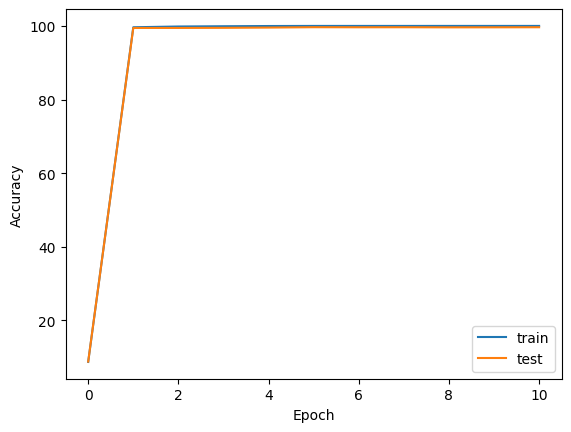

In [7]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

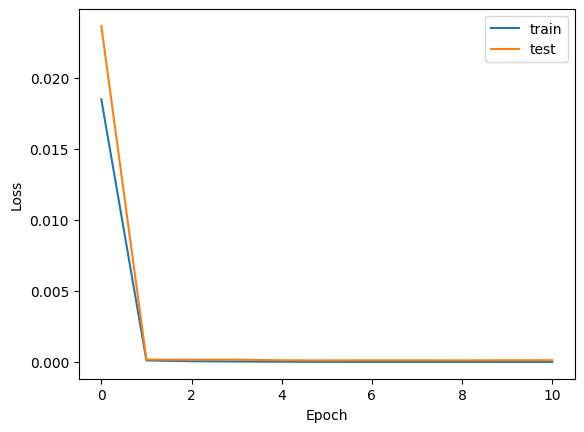

In [8]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


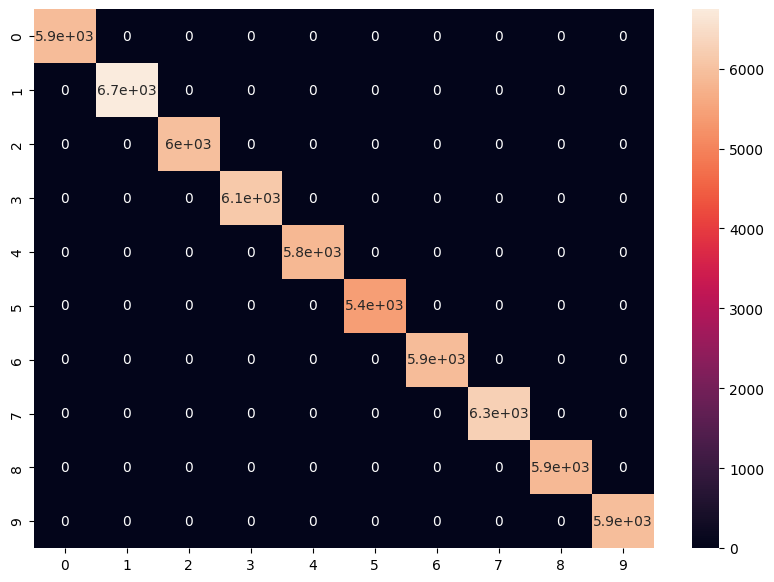

[ 각 클래스에 따른 정확도 ]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
[ 전체 평균 정확도 ]
tensor(1.)


In [9]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, transfer_train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


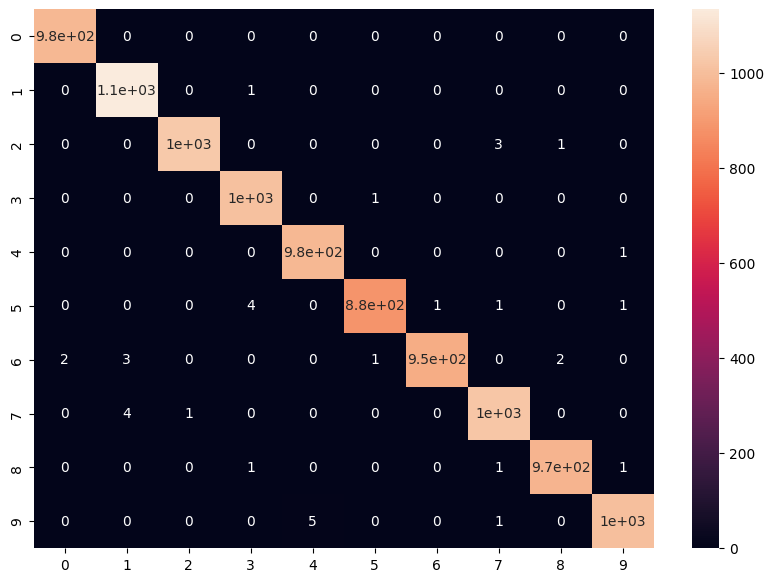

[ 각 클래스에 따른 정확도 ]
tensor([1.0000, 0.9991, 0.9961, 0.9990, 0.9990, 0.9922, 0.9916, 0.9951, 0.9969,
        0.9941])
[ 전체 평균 정확도 ]
tensor(0.9964)


In [10]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, transfer_test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

### 학습 이후 학습된 모델 다운로드 하기

In [11]:
from google.colab import files

In [12]:
files.download("./checkpoint/Transfer_Learning_MNIST.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>